In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import copy
from PIL import Image
from scipy import ndimage
np.random.seed(0)

In [2]:
num_px = 64

In [3]:
X_train = np.empty((num_px*num_px*3,0))
X_test = np.empty((num_px*num_px*3,0))

In [4]:
folder_path = "..."
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path,filename)
    if filename.endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tiff')):
        img_array = np.array(Image.open(file_path).resize((num_px,num_px)))
        img_array = img_array/255
        img_array = img_array.reshape((num_px*num_px*3,1))
        X_train = np.column_stack((X_train,img_array))

folder_path = "..."
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path,filename)
    if filename.endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tiff')):
        img_array = np.array(Image.open(file_path).resize((num_px,num_px)))
        img_array = img_array/255
        img_array = img_array.reshape((num_px*num_px*3,1))
        X_test = np.column_stack((X_test,img_array))

In [5]:
print(X_train.shape)
Y_train = np.ones((1, X_train.shape[1]))
print(Y_train.shape)

print(X_test.shape)
Y_test = np.zeros((1, X_test.shape[1]))
print(Y_test.shape)

(12288, 99)
(1, 99)
(12288, 137)
(1, 137)


# Building the neural network

In [6]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z 
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

In [7]:
def init_params(layer_dims):
    np.random.seed(0)
    parameters = {}
    L = len(layer_dims)

    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l],1))

    return parameters

In [8]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A,W,b)
    return Z, cache

In [9]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    if activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    # print('z'+str(activation_cache.shape))
    return A, cache

In [10]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation = 'relu')
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation = 'sigmoid')
    caches.append(cache)
    return AL, caches

In [11]:
def compute_cost(AL,Y):
    m = Y.shape[1]
    cost = (-1/m)*np.sum((Y*np.log(AL))+(1-Y)*(np.log(1-AL)))
    cost = np.squeeze(cost)
    return cost

In [12]:
def linear_backward(dZ,cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    # print(f"Shape of W: {W.shape}")
    # print(f"Shape of W.T: {W.T.shape}")
    # print(f"Shape of dZ: {dZ.shape}")
    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

In [13]:
def relu_backward(dA, cache):
    Z = cache  # Z comes from the activation cache
    # Ensure that dA and Z have the same shape
    dZ = np.array(dA, copy=True)  # Just converting dA to a correct object.
    
    # Apply the ReLU derivative: When Z <= 0, set dZ to 0
    dZ[Z <= 0] = 0  # This works element-wise when Z and dZ have the same shape
    
    return dZ



def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)    
    return dZ



In [14]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [15]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation='sigmoid')
    grads['dA' + str(L-1)] = dA_prev_temp
    grads['dW' + str(L)] = dW_temp
    grads['db' + str(L)] = db_temp
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads['dA' + str(l+1)], current_cache, activation = 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [16]:
def update_parameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2

    for l in range(L):
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate*grads['dW'+str(l+1)]
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate*grads['db'+str(l+1)]
    return parameters

In [17]:
layers_dims = [12288,5,1]

In [18]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=100, print_cost=False):
    np.random.seed(1)
    costs = []
    parameters = init_params(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL,Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i%100 == 0 or i == num_iterations-1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

In [19]:
parameters, costs = L_layer_model(X_train, Y_train, layers_dims, learning_rate=0.005, num_iterations = 1000, print_cost=True)

Cost after iteration 0: 0.6890380186561618
Cost after iteration 100: 0.014602509781818193
Cost after iteration 200: 0.005338524236843249
Cost after iteration 300: 0.003163100377594355
Cost after iteration 400: 0.0022180550988653886
Cost after iteration 500: 0.0016955177823558625
Cost after iteration 600: 0.001365955952757102
Cost after iteration 700: 0.0011400302069961331
Cost after iteration 800: 0.0009759545743408947
Cost after iteration 900: 0.0008516447529572126
Cost after iteration 999: 0.0007552288245603598


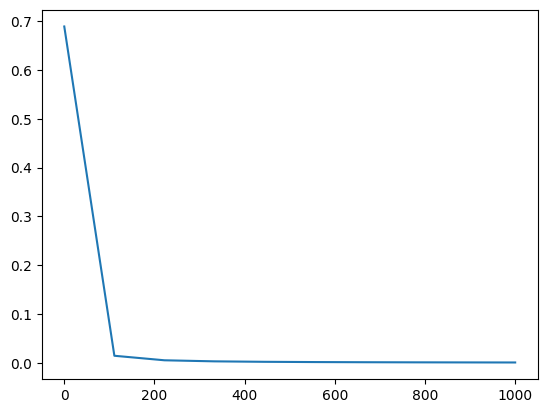

In [20]:
  # Assuming costs is an array of length 100
x_values = np.linspace(0, 1000, 10)

plt.plot(x_values, costs)

In [21]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    print ("predictions: " + str(p))
    print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [22]:
pred_train = predict(X_train, Y_train, parameters)

predictions: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1.]]
true labels: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1.]]
Accuracy: 0.9999999999999998


In [23]:
pred_test = predict(X_test, Y_test, parameters)

predictions: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
true labels: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Accuracy: 0.0


predictions: [[1.]]
true labels: [0]
Accuracy: 0.0


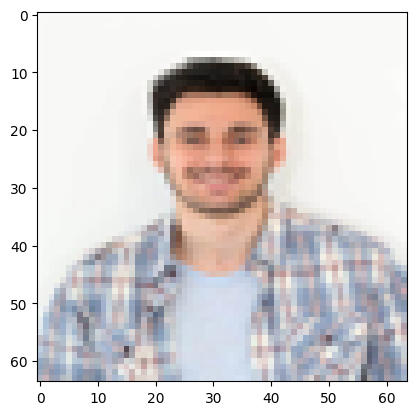

In [24]:
my_label_y = [0]
fname = ".."
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)



In [25]:
parameters

{'W1': array([[ 0.01764545,  0.00400699,  0.0097932 , ...,  0.00509183,
         -0.00158245,  0.00691701],
        [ 0.00113597,  0.00438143, -0.0003704 , ...,  0.00324184,
         -0.00142499, -0.00834714],
        [-0.0029651 ,  0.00806401,  0.00864032, ..., -0.01057422,
          0.00137733, -0.00181752],
        [ 0.00445315, -0.00586503, -0.00336699, ...,  0.0080374 ,
         -0.00572747, -0.00247237],
        [-0.00136051,  0.00084651,  0.01117479, ..., -0.00433503,
          0.00742167, -0.00932612]]),
 'b1': array([[1.30418477e-05],
        [1.23114023e-02],
        [0.00000000e+00],
        [3.40475549e-03],
        [1.36710682e-04]]),
 'W2': array([[ 0.00391784,  0.44679051, -0.00709447,  0.12224685,  0.00763293]]),
 'b2': array([[0.09064258]])}